# SpikeInterface DEMO v0.99 -  Neuralnet - November 2023

# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Data compression](#compression)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Viewers](#viewers)
* [9. Spike sorting comparison](#comparison)
* [10. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

For this demo we will use a small file provided by Eduarda Centeno, Arthur Leblois and Aude Retailleau from IMN lab in Bordeaux.
It is a recording from a zebra finch for testing the probe ASSY-236-H5 from cambridge neurotech.
The recording system is the openephys usb3 board.
This file is only for testing or teaching purposes.


The dataset can be download here
https://drive.google.com/drive/folders/17RlgsMLheW82IMLMgmTFifVACebDZ8X5?usp=sharing

In [3]:
import spikeinterface.full as si

In [4]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.99.0.dev0


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

More documention on this section can be found here: https://spikeinterface.readthedocs.io/en/latest/modules/core.html

In [51]:
download_directory = Path("the/directory/where/you/downloaded/the/data")
download_directory = Path("/home/heberto/Downloads")

base_folder = download_directory / "cambridgeneurotech_openephys_recording"
oe_folder = base_folder / "openephys_recording" / "2023-08-23_15-56-05"
assert oe_folder.is_dir(), f"Folder not found in path: {oe_folder}. Please check the path to the data."


In [7]:
full_raw_rec = si.read_openephys(oe_folder)


The `read_openephys()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [8]:
full_raw_rec

OpenEphysBinaryRecordingExtractor: 72 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                   300.00s (5.00 minutes) - int16 dtype - 1.21 GiB

Our recording is 64 ephys channels and 8 auxs

In [9]:
full_raw_rec.channel_ids

array(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9',
       'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17',
       'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25',
       'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32', 'CH33',
       'CH34', 'CH35', 'CH36', 'CH37', 'CH38', 'CH39', 'CH40', 'CH41',
       'CH42', 'CH43', 'CH44', 'CH45', 'CH46', 'CH47', 'CH48', 'CH49',
       'CH50', 'CH51', 'CH52', 'CH53', 'CH54', 'CH55', 'CH56', 'CH57',
       'CH58', 'CH59', 'CH60', 'CH61', 'CH62', 'CH63', 'CH64', 'ADC1',
       'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8'],
      dtype='<U64')

`spikeinterface.extractors` integrate many readers

In [10]:
si.recording_extractor_full_dict

{'binaryfolder': spikeinterface.core.binaryfolder.BinaryFolderRecording,
 'binary': spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 'zarr': spikeinterface.core.zarrrecordingextractor.ZarrRecordingExtractor,
 'numpy': spikeinterface.core.numpyextractors.NumpyRecording,
 'shybrid': spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 'mda': spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 'nwb': spikeinterface.extractors.nwbextractors.NwbRecordingExtractor,
 'cbin_ibl': spikeinterface.extractors.cbin_ibl.CompressedBinaryIblExtractor,
 'ibl_streaming_recording': spikeinterface.extractors.iblstreamingrecording.IblStreamingRecordingExtractor,
 'mcsh5': spikeinterface.extractors.mcsh5extractors.MCSH5RecordingExtractor,
 'alphaomega': spikeinterface.extractors.neoextractors.alphaomega.AlphaOmegaRecordingExtractor,
 'axona': spikeinterface.extractors.neoextractors.axona.AxonaRecordingExtractor,
 'biocam': spikeinterface.extractors.neoex

A `Recording` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `NwbRecording` is designed specifically for NWB files.

Here we retrieve information from the recording using the built-in functions from the `Recording`:

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces(start_frame, end_frame, channel_ids)` function returns a numpy array with (T, N) shape. Here, N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [11]:
fs = full_raw_rec.get_sampling_frequency()
trace_snippet = full_raw_rec.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [12]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 72)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [13]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [14]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-236-H5 - 64ch - 1shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [15]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [16]:
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')

(-50.0, 500.0)

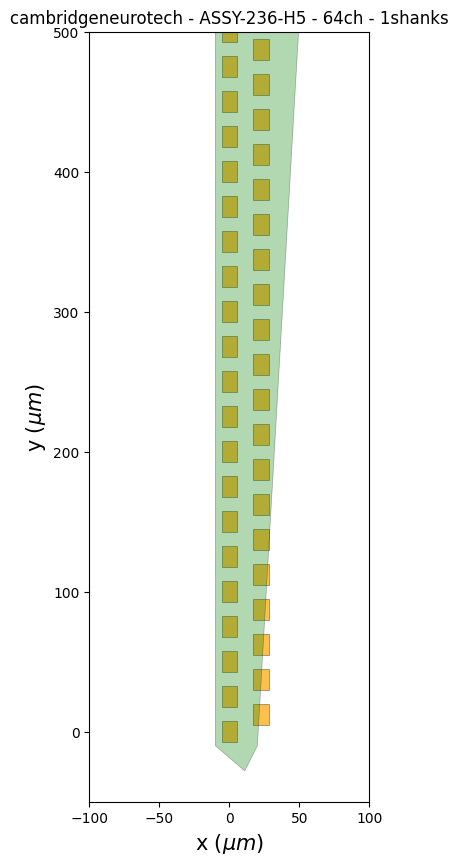

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 500)

(-50.0, 300.0)

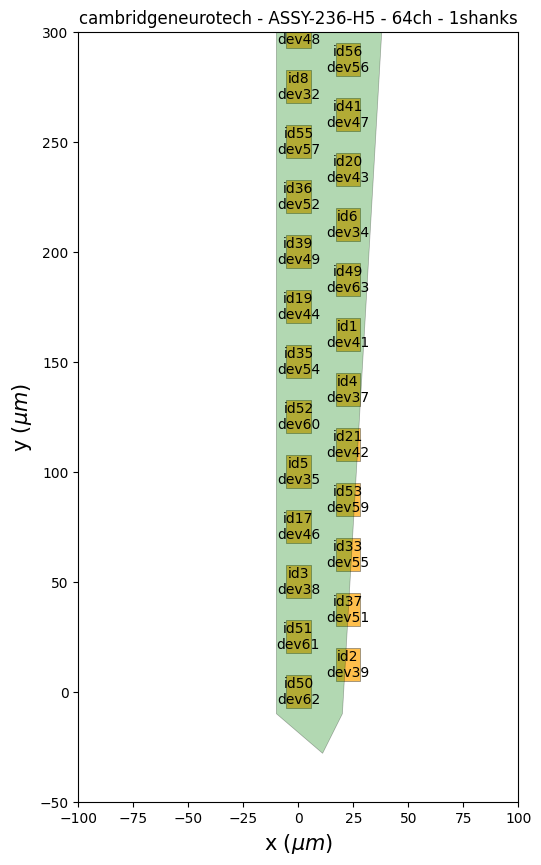

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize a sample of their information as a `pandas` dataframe:

In [22]:
probe.to_dataframe(complete=True)[["contact_ids", "shank_ids", "device_channel_indices"]].sample(10)

,contact_ids,shank_ids,device_channel_indices
0,1,,41
8,9,,29
16,17,,46
11,12,,26
55,56,,56
43,44,,12
4,5,,35
59,60,,4
57,58,,6
35,36,,52


When loading the probe, the device indices (and all the other contact properties) are automatically sorted.
And very importantly the recording is reduce to 64 channels! That is, the aux channels are removed.

In [24]:
raw_rec = full_raw_rec.set_probe(probe)
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [25]:
probe_rec = raw_rec.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]

,contact_ids,device_channel_indices
0,64,0
1,63,1
2,62,2
3,61,3
4,60,4
...,...,...
59,53,59
60,52,60
61,51,61
62,50,62


We can now visualize the channel_id (channel name) from open ephys.

(-50.0, 300.0)

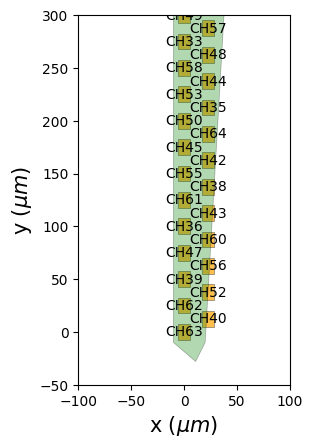

In [26]:
fig, ax = plt.subplots()
si.plot_probe_map(raw_rec, with_channel_ids=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [70]:
%matplotlib widget
si.plot_traces(raw_rec, backend="ipywidgets", mode='line', channel_ids=raw_rec.channel_ids[::8]);

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Layout).__init__(layout=Layout(width='95%')).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(VBox).__init__(align_items='center').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [29]:
print("Properties:\n", list(raw_rec.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group']


Let's add some new properties! 
The first 192 channels are in the CA1 area, the second 192 are in the CA3 area:

In [30]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [31]:
raw_rec.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [32]:
print(raw_rec._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'brain_area'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [33]:
raw_rec.annotate(description="Dataset for SI tutorial")

In [34]:
print(raw_rec.get_annotation_keys())

['is_filtered', 'probes_info', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.
All preprocessing modules return new `Recording` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data. This creates a common interface for handling electrophysiology data and in most cases is also lazy so it avoids unnecessary memory usage.

Examples of common preprocessing steps are: 
* Filtering,
* Common median reference
* Whitening
* Etc.

For this notebook, let's filter the recordings and apply common median reference (CMR). 

More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html


Below, we bandpass filter the recording and apply common median reference to the original recording:

In [37]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)

Let's now apply Common Median Reference (CMR):

In [38]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [39]:
w = si.plot_traces({"filt": recording_f, "common": recording_cmr}, mode='map',
                        time_range=[10, 10.1],
                        backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## remove bad channels



In [40]:
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f, method='coherence+psd')
print('bad_channel_ids', bad_channel_ids)
print('channel_labels', channel_labels)

bad_channel_ids ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH62' 'CH63' 'CH64']
channel_labels ['dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'out'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'dead' 'dead' 'dead' 'dead'
 'dead' 'out' 'out' 'dead']


In [41]:
recording_good_channels_f = recording_f.remove_channels(bad_channel_ids)
recording_good_channels = si.common_reference(recording_good_channels_f, reference='global', operator='median')

print(recording_good_channels)
print(recording_good_channels.channel_ids)

CommonReferenceRecording: 47 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - int16 dtype - 806.81 MiB
['CH9' 'CH10' 'CH11' 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18'
 'CH19' 'CH20' 'CH21' 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28'
 'CH29' 'CH30' 'CH31' 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38'
 'CH39' 'CH41' 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49'
 'CH50' 'CH51' 'CH52' 'CH53' 'CH54' 'CH55' 'CH56']


In [42]:
w = si.plot_traces(recording_good_channels, mode='map',
                        time_range=[10, 10.1],
                        backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [46]:
fs = recording_cmr.get_sampling_frequency()

start_frame = int(0*fs)  
end_frame =int(300*fs)  # 5 minutes
recording_sub = recording_cmr.frame_slice(start_frame=start_frame, end_frame=end_frame)
recording_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [47]:
raw_rec_sub = raw_rec.frame_slice(start_frame=start_frame, end_frame=end_frame)
raw_rec_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [48]:
job_kwargs = dict(n_jobs=30, chunk_duration="1s", progress_bar=True)

In [52]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)

write_binary_recording with n_jobs = 30 and chunk_size = 30000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [53]:
recording_saved

BinaryFolderRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [54]:
!ls -llh {base_folder}/preprocessed

total 1,1G
-rw-rw-r-- 1 heberto heberto 7,9K nov  4 11:44 binary.json
-rw-rw-r-- 1 heberto heberto  34K nov  4 11:44 probe.json
drwxrwxr-x 2 heberto heberto 4,0K nov  4 11:44 properties
-rw-rw-r-- 1 heberto heberto  78K nov  4 11:44 provenance.json
-rw-rw-r-- 1 heberto heberto 9,5K nov  4 11:44 si_folder.json
-rw-rw-r-- 1 heberto heberto 1,1G nov  4 11:44 traces_cached_seg0.raw


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [55]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')


Cached channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


After saving the SI object, we can easily load it back in a new session:

In [56]:
recording_loaded = si.load_extractor(base_folder / "preprocessed")

In [57]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')


Loaded channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


**IMPORTANT**:
 * the same saving mechanisms are available also for all SortingExtractor
 * we can use other format like zarr for saving which use compression

**Saving with compressed format**

In [58]:
import numcodecs

In [59]:
if (base_folder / "preprocessed_compressed.zarr").is_dir():
    recording_saved = si.read_zarr(base_folder / "preprocessed_compressed.zarr")
else:
    import numcodecs
    compressor = numcodecs.Blosc(cname="zstd", clevel=9, shuffle=numcodecs.Blosc.BITSHUFFLE)
    recording_saved = recording_sub.save(format="zarr", folder=base_folder / "preprocessed_compressed.zarr",
                                         compressor=compressor,
                                         **job_kwargs)

write_zarr_recording with n_jobs = 30 and chunk_size = 30000


write_zarr_recording:   0%|          | 0/300 [00:00<?, ?it/s]

In [60]:
!du -sh {base_folder}/preprocessed_compressed.zarr
!du -sh {base_folder}/preprocessed

526M	/home/heberto/Downloads/cambridgeneurotech_openephys_recording/preprocessed_compressed.zarr
1,1G	/home/heberto/Downloads/cambridgeneurotech_openephys_recording/preprocessed


TODO Alessio : put a link

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.



More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html

In [61]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [62]:
si.installed_sorters()

/home/heberto/development/spikeinterface/src/spikeinterface/sorters/external/waveclus.py:124: ResourceWarning: unclosed file <_io.TextIOWrapper name=93 encoding='UTF-8'>
  if cls.check_compiled():
/home/heberto/development/spikeinterface/src/spikeinterface/sorters/external/waveclus_snippets.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name=93 encoding='UTF-8'>
  if cls.check_compiled():


['mountainsort4', 'spykingcircus2', 'tridesclous', 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

For matlab based sorter we need to set the path of the source code

In [63]:
path_of_kilosort2_5 = Path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')
if path_of_kilosort2_5.is_file():
    si.Kilosort2_5Sorter.set_kilosort2_5_path(path_of_kilosort2_5)
    si.installed_sorters()
else:
    print(f"Kilosort2.5 not found in {path_of_kilosort2_5}")

Kilosort2.5 not found in /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [64]:
si.get_default_sorter_params('kilosort2_5')

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 16,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [65]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: str,
    recording: spikeinterface.core.baserecording.BaseRecording,
    output_folder: Optional[str] = None,
    remove_existing_folder: bool = False,
    delete_output_folder: bool = False,
    verbose: bool = False,
    raise_error: bool = True,
    docker_image: Union[bool, str, NoneType] = False,
    singularity_image: Union[bool, str, NoneType] = False,
    delete_container_files: bool = True,
    with_output: bool = True,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool, default: False
    If True, output folder is deleted
verbose: bool, default: False
    If True, output is verbose
raise_error: bool,

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

### Run sorter locally

In [66]:
sorter_params = {'do_correction': False}

In [67]:
# run spike sorting on entire recording
sorting_KS25 = si.run_sorter(sorter_name='kilosort2_5', recording=recording_saved,
                             output_folder=base_folder / 'results_KS25',
                             verbose=True, **sorter_params, **job_kwargs)

/home/heberto/development/spikeinterface/src/spikeinterface/sorters/external/kilosort2_5.py:115: ResourceWarning: unclosed file <_io.TextIOWrapper name=94 encoding='UTF-8'>
  if cls.check_compiled():


Exception: The sorter kilosort2_5 is not installed.Please install it with:  

To use Kilosort2.5 run:

        >>> git clone https://github.com/MouseLand/Kilosort
    and provide the installation path by setting the KILOSORT2_5_PATH
    environment variables or using Kilosort2_5Sorter.set_kilosort2_5_path().



    More information on Kilosort2.5 at:
        https://github.com/MouseLand/Kilosort
     

We can check the output object:

In [56]:
sorting_KS25

KiloSortSortingExtractor: 156 units - 1 segments - 30.0kHz

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [57]:
!ls -llh {base_folder}/results_KS25

total 24K
drwxrwx--- 2 samuel.garcia crnl 4,0K nov.   4 09:56 sorter_output
-rw-rw---- 1 samuel.garcia crnl 2,2K nov.   4 09:56 spikeinterface_log.json
-rw-rw---- 1 samuel.garcia crnl  943 nov.   4 09:55 spikeinterface_params.json
-rw-rw---- 1 samuel.garcia crnl 9,6K nov.   4 09:55 spikeinterface_recording.json


In [78]:
!cat {base_folder}/results_KS25/spikeinterface_params.json

{
    "sorter_name": "kilosort2_5",
    "sorter_params": {
        "detect_threshold": 6,
        "projection_threshold": [
            10,
            4
        ],
        "preclust_threshold": 8,
        "car": true,
        "minFR": 0.1,
        "minfr_goodchannels": 0.1,
        "nblocks": 5,
        "sig": 20,
        "freq_min": 150,
        "sigmaMask": 30,
        "nPCs": 3,
        "ntbuff": 64,
        "nfilt_factor": 4,
        "NT": 65600,
        "AUCsplit": 0.9,
        "do_correction": false,
        "wave_length": 61,
        "keep_good_only": false,
        "skip_kilosort_preprocessing": false,
        "scaleproc": null,
        "save_rez_to_mat": false,
        "delete_tmp_files": [
            "matlab_files"
        ],
        "delete_recording_dat": false,
        "n_jobs": 30,
        "chunk_duration": "1s",
        "progress_bar": true,
        "mp_context": null,
        "max_threads_per_process": 1
    }
}

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [58]:
print(f'Spike train of a unit: {sorting_KS25.get_unit_spike_train(unit_id=1)}')
print(f'Spike train of a unit (in s): {sorting_KS25.get_unit_spike_train(unit_id=1, return_times=True)}')

Spike train of a unit: [    753    8618    8978 ... 8985774 8985847 8985902]
Spike train of a unit (in s): [352.9851     353.24726667 353.25926667 ... 652.4858     652.48823333
 652.49006667]


We can use `widgets` functions for some quick visualizations:

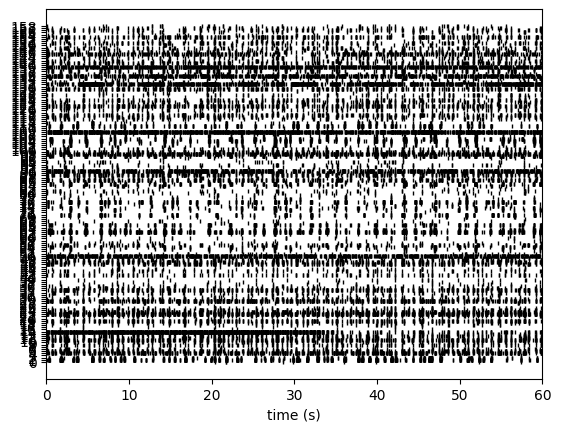

In [59]:
%matplotlib inline
w_rs = si.plot_rasters(sorting_KS25, time_range=(0, 60))

We can also save a spike sorting output for future use:

In [60]:
sorting_saved_KS25 = sorting_KS25.save(folder=base_folder / "sorting_KS25")

In [61]:
sorting_loaded_KS25 = si.load_extractor(base_folder / "sorting_KS25")
sorting_loaded_KS25

NumpyFolderSorting: 156 units - 1 segments - 30.0kHz

### Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)

See this documentation : https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html#running-sorters-in-docker-singularity-containers

When docker/singularity is installed, you can simply run the sorter in a container image:

In [68]:
# run spike sorting on entire recording
sorting_KS2 = si.run_sorter('kilosort2', recording_saved, 
                            output_folder=base_folder / 'results_KS2',
                            verbose=True,
                            docker_image=True, 
                            **job_kwargs)

AssertionError: The container requires a NVIDIA GPU capability, but it is not available

In [65]:
sorting_KS2

KiloSortSortingExtractor: 162 units - 1 segments - 30.0kHz

In [66]:
print(f'KS2 found {len(sorting_KS2.get_unit_ids())} units')

KS2 found 162 units


### Run internal sorter : spykingcircus2

In [69]:
sorting_SC2 = si.run_sorter('spykingcircus2', recording_saved, 
                            output_folder=base_folder / 'results_SC2',
                            verbose=True, job_kwargs=job_kwargs)

detect peaks using locally_exclusive with n_jobs = 30 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

We found 112237 peaks in total
We kept 112237 peaks for clustering
extracting features with n_jobs = 30 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

We found 82 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 30 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

extract waveforms shared_memory multi buffer with n_jobs = 30 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

We kept 71 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 30 and chunk_size = 30000


/home/heberto/development/spikeinterface/src/spikeinterface/sortingcomponents/clustering/clustering_tools.py:669: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/heberto/Downloads/cambridgeneurotech_openephys_recording/results_SC2/sorter_output/clustering/tmp.raw' mode='r' encoding='UTF-8'>
  del recording, sub_recording, local_params, waveform_extractor


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

extract waveforms shared_memory multi buffer with n_jobs = 30 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

find spikes (circus-omp-svd) with n_jobs = 30 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/envs/spikeinterface_env/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe23cb70460>
  self.pid = os.fork()
/home/heberto/miniconda3/

We found 288678 spikes
spykingcircus2 run time 207.94s


In [71]:
sorting_SC2

NumpyFolderSorting: 71 units - 1 segments - 30.0kHz

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [72]:
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_KS25


In [73]:
si.extract_waveforms?

Signature:
si.extract_waveforms(
    recording,
    sorting,
    folder=None,
    mode='folder',
    precompute_template=('average',),
    ms_before=1.0,
    ms_after=2.0,
    max_spikes_per_unit=500,
    overwrite=False,
    return_scaled=True,
    dtype=None,
    sparse=True,
    sparsity=None,
    sparsity_temp_folder=None,
    num_spikes_for_sparsity=100,
    unit_batch_size=200,
    allow_unfiltered=False,
    use_relative_path=False,
    seed=None,
    load_if_exists=None,
    **kwargs,
)
Docstring:
Extracts waveform on paired Recording-Sorting objects.
Waveforms can be persistent on disk (`mode`="folder") or in-memory (`mode`="memory").
By default, waveforms are extracted on a subset of the spikes (`max_spikes_per_unit`) and on all channels (dense).
If the `sparse` parameter is set to True, a sparsity is estimated using a small number of spikes
(`num_spikes_for_sparsity`) and waveforms are extracted and saved in sparse mode.


Parameters
----------
recording: Recording
    The r

In [74]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_dense", 
                          sparse=False,
                          overwrite=True, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:30 after:60 n_per_units:500


Now all waveforms are computed and stored in the provided `waveforms` folder. We can now retrieve waveforms and templates easily:

In [75]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (28, 90, 64)
Template shape: (90, 64)
All templates shape: (156, 90, 64)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

We can also render interactive plots with the `ipywidgets` backend!

In [76]:
%matplotlib widget
w = si.plot_unit_templates(we,backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [77]:
for unit in sorting.get_unit_ids()[::10]:
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 28 - num spikes: 28
Unit 10 - num waveforms: 500 - num spikes: 3046
Unit 20 - num waveforms: 125 - num spikes: 125
Unit 30 - num waveforms: 238 - num spikes: 238
Unit 41 - num waveforms: 500 - num spikes: 600
Unit 51 - num waveforms: 243 - num spikes: 243
Unit 62 - num waveforms: 500 - num spikes: 3752
Unit 72 - num waveforms: 484 - num spikes: 484
Unit 82 - num waveforms: 81 - num spikes: 81
Unit 92 - num waveforms: 245 - num spikes: 245
Unit 102 - num waveforms: 500 - num spikes: 735
Unit 113 - num waveforms: 328 - num spikes: 328
Unit 123 - num waveforms: 500 - num spikes: 887
Unit 133 - num waveforms: 195 - num spikes: 195
Unit 143 - num waveforms: 500 - num spikes: 630
Unit 153 - num waveforms: 500 - num spikes: 1623


No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we could use the `max_spikes_per_unit` argument, but this would be crazy:

```
we_all = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_all", 
                              max_spikes_per_unit=None,
                              overwrite=True,
                              **job_kwargs)
```

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels.
In order to find a subset of channels for each unit, we can use the `compute_sparsity()` which give an object of sparsity per unit.

In [78]:
sparsity = si.compute_sparsity(we, method='radius', radius_um=100.0)
sparsity

ChannelSparsity - units: 156 - channels: 64 - density, P(x=1): 0.26

In [79]:
#  check the sparsity for some units
for unit_id in sorting.unit_ids[::30]:
    print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))

0 ['CH33', 'CH35', 'CH36', 'CH38', 'CH42', 'CH43', 'CH44', 'CH45', 'CH48', 'CH50', 'CH53', 'CH55', 'CH57', 'CH58', 'CH60', 'CH61', 'CH64']
30 ['CH2', 'CH3', 'CH10', 'CH11', 'CH12', 'CH13', 'CH17', 'CH19', 'CH23', 'CH25', 'CH29', 'CH34', 'CH37', 'CH46', 'CH51', 'CH54', 'CH59']
62 ['CH36', 'CH38', 'CH39', 'CH40', 'CH43', 'CH47', 'CH52', 'CH55', 'CH56', 'CH60', 'CH61', 'CH62', 'CH63']
92 ['CH2', 'CH10', 'CH23', 'CH33', 'CH34', 'CH37', 'CH41', 'CH44', 'CH46', 'CH48', 'CH49', 'CH51', 'CH53', 'CH54', 'CH57', 'CH58', 'CH59']
123 ['CH1', 'CH4', 'CH5', 'CH6', 'CH7', 'CH9', 'CH16', 'CH20', 'CH21', 'CH22', 'CH24', 'CH26', 'CH27', 'CH28', 'CH30', 'CH31', 'CH32']
153 ['CH1', 'CH4', 'CH5', 'CH6', 'CH7', 'CH9', 'CH16', 'CH20', 'CH21', 'CH22', 'CH24', 'CH26', 'CH27', 'CH28', 'CH30', 'CH31', 'CH32']


In [80]:
## lets use this sparsity object to extract waveforms again

In [81]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse_explicit", 
                          sparsity=sparsity, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [82]:
# the waveforms are now sparse
for unit_id in we.unit_ids[::10]:
    waveforms = we.get_waveforms(unit_id=unit_id)
    print(unit_id, waveforms.shape)

0 (28, 90, 17)
10 (500, 90, 17)
20 (125, 90, 15)
30 (238, 90, 17)
41 (500, 90, 17)
51 (243, 90, 17)
62 (500, 90, 13)
72 (484, 90, 17)
82 (81, 90, 17)
92 (245, 90, 17)
102 (500, 90, 17)
113 (328, 90, 17)
123 (500, 90, 17)
133 (195, 90, 17)
143 (500, 90, 17)
153 (500, 90, 17)


we can also auto estimate the sparsity directly on waveforms extraction, this avoid extacting twice (one dense + one sparse)

In [83]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse", 
                          sparse=True, **job_kwargs)
print(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [84]:
# and we can acces the sparsity as an attributes of the object
print(we.sparsity)

ChannelSparsity - units: 156 - channels: 64 - density, P(x=1): 0.26


Most of the plotting and exporting functions accept `sparsity` as an argument. 

In [85]:
%matplotlib widget
si.plot_unit_templates(we, backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.


See also : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [91]:
pc = si.compute_principal_components(we, n_components=3,
                                        load_if_exists=False,
                                         **job_kwargs)

Fitting PCA:   0%|          | 0/156 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/156 [00:00<?, ?it/s]

In [92]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (28, 3, 64)
All PC scores shape: (54902, 3, 64)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

For more details see this https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#waveformextractor-extensions


In [93]:
we.get_available_extension_names()

['principal_components']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [94]:
pc = we.load_extension("principal_components")
print(pc)

WaveformPrincipalComponent: 64 channels - 1 segments
  mode: by_channel_local n_components: 3


In [95]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

(54902, 3, 64)


### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [96]:
amplitudes = si.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, 
                                            **job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [97]:
amplitudes[0][15]

array([ -30.419998 ,  -38.609997 ,  -50.309998 ,  -47.969997 ,
        -17.744999 ,  -53.624996 ,  -29.835    ,  -19.695    ,
         -9.945    ,  -50.114998 ,  -37.05     ,  -38.219997 ,
        -28.275    ,  -35.684998 ,  -16.574999 ,  -10.335    ,
        -28.859999 ,  -27.494999 ,  -40.949997 ,   -6.825    ,
        -32.37     ,    3.8999999,  -45.434998 ,    1.9499999,
        -19.304998 ,  -47.579998 ,  -37.245    ,  -33.149998 ,
        -46.019997 ,  -15.405    ,  -24.57     ,  -50.699997 ,
        -23.789999 ,  -70.784996 ,  -23.009998 ,  -46.215    ,
        -17.744999 ,  -21.644999 ,  -43.875    ,  -17.355    ,
        -22.425    , -102.17999  ,  -24.765    ,  -11.115    ,
        -76.049995 ,  -28.079998 ,  -30.419998 ,  -38.609997 ,
        -40.754997 ,   -2.34     ,  -27.105    ,  -58.89     ,
        -31.199999 ,  -13.259999 ,  -15.209999 ,  -33.93     ,
          6.825    ,  -46.019997 ,  -31.784998 ], dtype=float32)

In [100]:
%matplotlib widget
si.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [101]:
unit_locations = si.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = si.compute_spike_locations(we, method="center_of_mass", load_if_exists=True,
                                                **job_kwargs)

In [102]:
%matplotlib widget
si.plot_unit_locations(we, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [103]:
%matplotlib widget
si.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

### Compute correlograms

In [104]:
ccgs, bins = si.compute_correlograms(we)

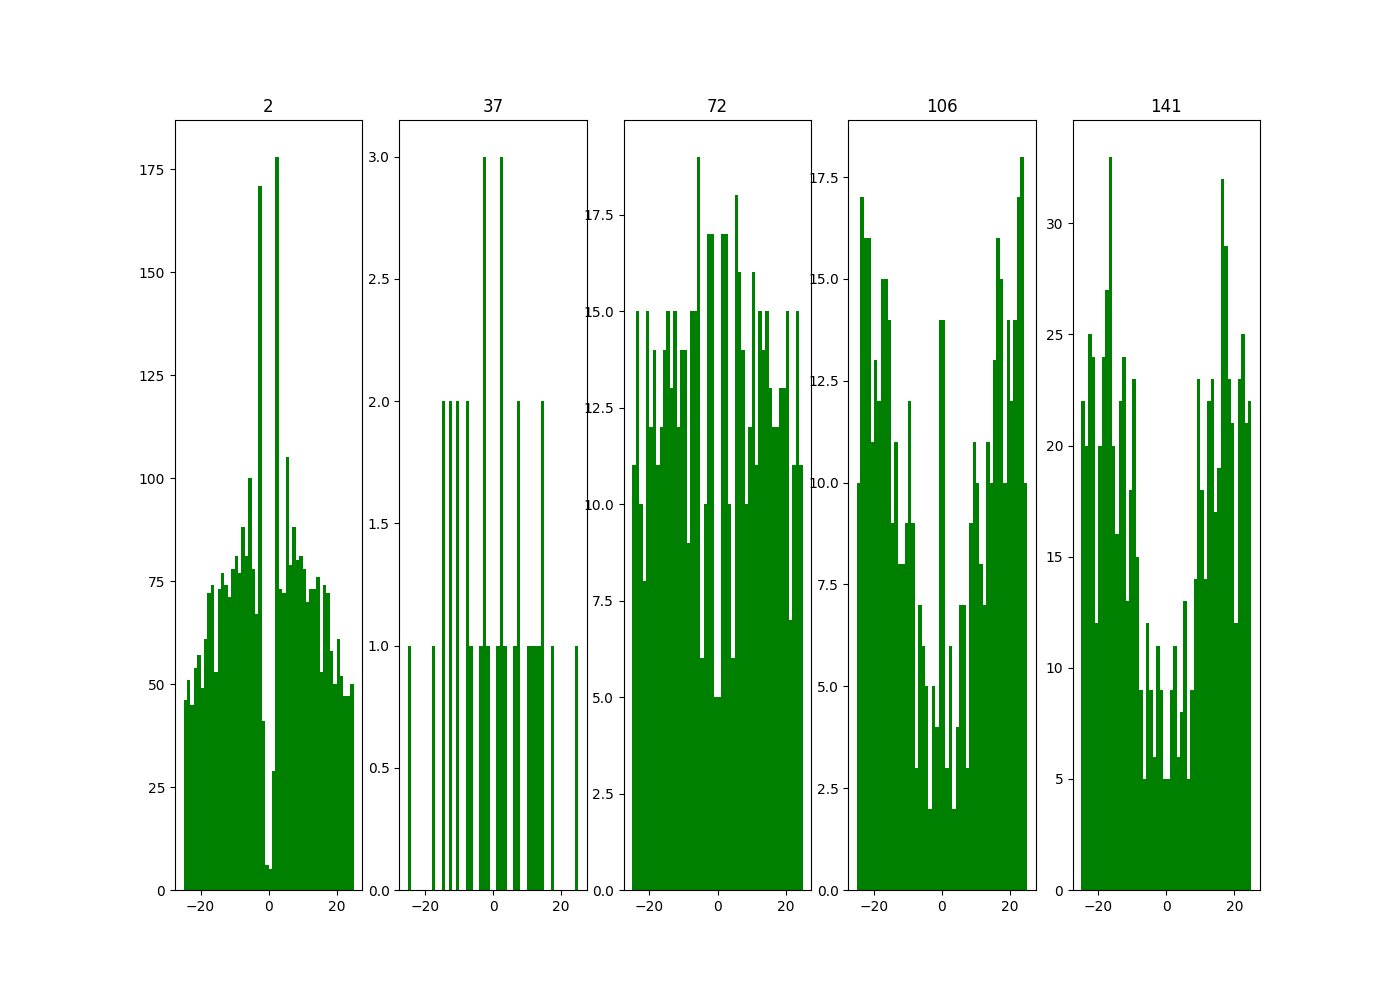

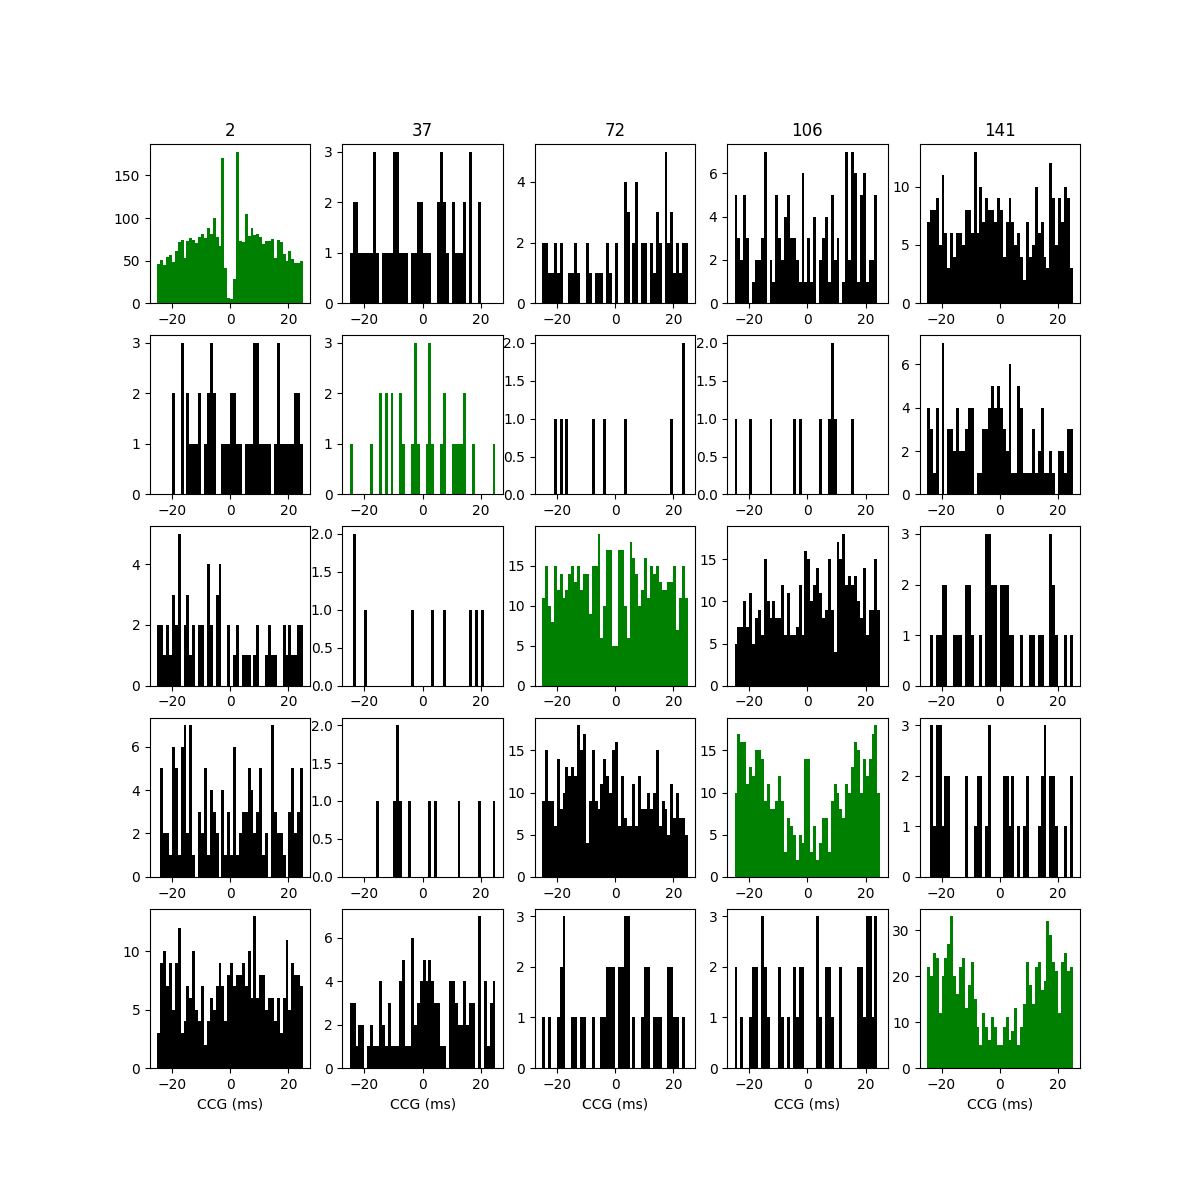

In [105]:
si.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[2::34], figsize=(14, 10))
si.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[2::34], figsize=(12, 12))

### Compute template similarity

In [106]:
similarity = si.compute_template_similarity(we)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [107]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [108]:
template_metrics = si.compute_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
0,0.001233,-0.375302,0.00073,48476.864899,-289979.761197,2,1
1,0.00091,-0.747168,0.000533,66049.781822,-41876.4844,2,2
2,0.00122,-0.290885,0.000577,33476.404881,-204954.594082,1,1
3,0.00135,-0.418664,0.000667,30632.380047,-257029.62426,2,1
4,0.0009,-0.266889,0.000307,83458.176826,-15135.618846,2,1
...,...,...,...,...,...,...,...
154,0.000383,-0.412954,0.00024,172016.85597,-19284.025537,1,1
155,0.000917,-0.341462,0.000313,114168.149826,-26819.953742,1,1
156,0.000873,-0.286777,0.000353,139106.608802,-20427.779971,2,1
157,0.000947,-0.285544,0.00029,168796.452655,-34604.336427,2,1


In [109]:
si.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

See also this : https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html

Let's see what metrics are available:

In [110]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [111]:
qm_params = si.get_default_qm_params()
qm_params

{'presence_ratio': {'bin_duration_s': 60, 'mean_fr_ratio_thresh': 0.0},
 'snr': {'peak_sign': 'neg',
  'peak_mode': 'extremum',
  'random_chunk_kwargs_dict': None},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'rp_violation': {'refractory_period_ms': 1.0, 'censored_period_ms': 0.0},
 'sliding_rp_violation': {'min_spikes': 0,
  'bin_size_ms': 0.25,
  'window_size_s': 1,
  'exclude_ref_period_below_ms': 0.5,
  'max_ref_period_ms': 10,
  'contamination_values': None},
 'synchrony': {'synchrony_sizes': (2, 4, 8)},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'amplitude_cv': {'average_num_spikes_per_bin': 50,
  'percentiles': (5, 95),
  'min_num_bins': 10,
  'amplitude_extension': 'spike_amplitudes'},
 'amplitude_cutoff': {'peak_sign': 'neg',
  'num_histogram_bins': 100,
  'histogram_smoothing_value': 3,
  'amplitudes_bins_min_ratio': 5},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'interval_s': 60,
  'min_spikes_per_interval': 100,
  'direction':

In [112]:
qm_params['isi_violation']['isi_threshold_ms'] = 1.1

In [113]:
metric_names = si.get_quality_metric_list()
# metric_names = si.get_quality_metric_list() + si.get_quality_pca_metric_list()
qm = si.compute_quality_metrics(we, metric_names=metric_names, verbose=True,  qm_params=qm_params, **job_kwargs)


Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median
Computing amplitude_cv
Computing synchrony
Computing firing_range
Computing drift


In [114]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,28.0,0.093333,1.0,4.774624,0.000000,0,0.000000,0,NaN,NaN,33.832500,NaN,NaN,0.142857,0.0,0.0,0.40,NaN,NaN,NaN
1,3114.0,10.380000,1.0,4.493679,2.292181,163,1.000000,155,NaN,0.000312,30.029999,0.443721,0.262773,0.037893,0.0,0.0,13.96,0.691679,0.248978,0.225388
2,1342.0,4.473333,1.0,3.755559,0.530019,7,0.976864,6,NaN,0.001529,23.789999,0.603015,0.270222,0.111773,0.0,0.0,6.41,0.917089,0.332838,0.183419
3,163.0,0.543333,1.0,3.805212,5.132434,1,1.000000,1,NaN,NaN,26.519999,NaN,NaN,0.116564,0.0,0.0,1.20,NaN,NaN,NaN
4,3502.0,11.673333,1.0,6.394165,0.878402,79,1.000000,79,NaN,0.000252,32.369999,0.370751,0.302970,0.032838,0.0,0.0,5.81,0.215339,0.078740,0.074157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,375.0,1.250000,1.0,5.037415,0.000000,0,0.000000,0,NaN,NaN,31.784998,NaN,NaN,0.037333,0.0,0.0,2.01,NaN,NaN,NaN
155,343.0,1.143333,1.0,6.907933,0.000000,0,0.000000,0,NaN,NaN,46.799999,NaN,NaN,0.084548,0.0,0.0,1.42,NaN,NaN,NaN
156,733.0,2.443333,1.0,8.149182,1.015198,4,1.000000,4,NaN,0.002302,50.894997,0.338767,0.420852,0.045020,0.0,0.0,2.21,1.613493,0.568305,0.353003
157,456.0,1.520000,1.0,11.431896,0.000000,0,0.000000,0,NaN,NaN,73.125000,NaN,NaN,0.057018,0.0,0.0,1.40,NaN,NaN,NaN


In [115]:
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.2 and amplitude cutoff < 0.9:

In [116]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [117]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.5


and then we can use the query to select units:

In [118]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([  5,   6,   9,  10,  13,  14,  21,  24,  35,  41,  46,  50,  62,
        63,  76,  88,  89,  90,  98, 102, 108, 116, 119, 121, 129, 131,
       135, 137, 139, 141, 143, 145, 153])

In [119]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 156
Number of units after curation: 33


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [120]:
we_curated = we.select_units(keep_unit_ids, new_folder=base_folder / "waveforms_curated")

In [121]:
print(we_curated)

WaveformExtractor: 64 channels - 33 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [122]:
%matplotlib widget
si.plot_unit_templates(we_curated, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [123]:
we_curated.get_available_extension_names()

['template_metrics',
 'similarity',
 'principal_components',
 'spike_amplitudes',
 'correlograms',
 'spike_locations',
 'unit_locations',
 'quality_metrics']

# 8. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [119]:
# !sigui {base_folder}/waveforms_sparse

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [121]:
w = si.plot_sorting_summary(we_curated, backend="sortingview")

TODO pu the link here

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### Compare two sorters

In [124]:
sorting_KS25 = si.read_sorter_folder(base_folder/"results_KS25")
sorting_KS2 = si.read_sorter_folder(base_folder/"results_KS2")
sorting_SC2 = si.read_sorter_folder(base_folder/"results_SC2")

In [125]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

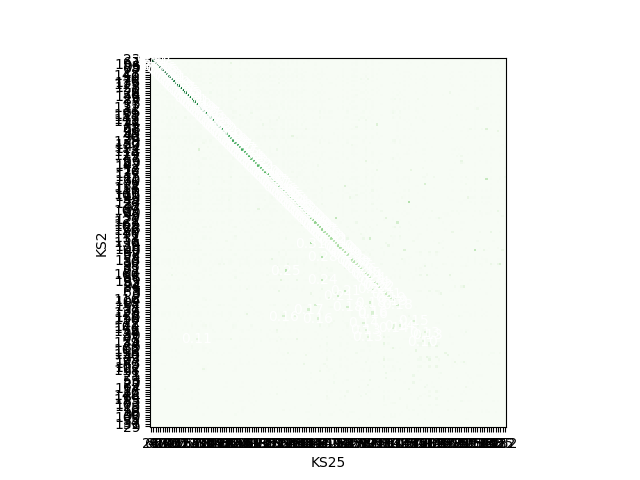

In [127]:
si.plot_agreement_matrix(comp_KS2_KS25)

In [128]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

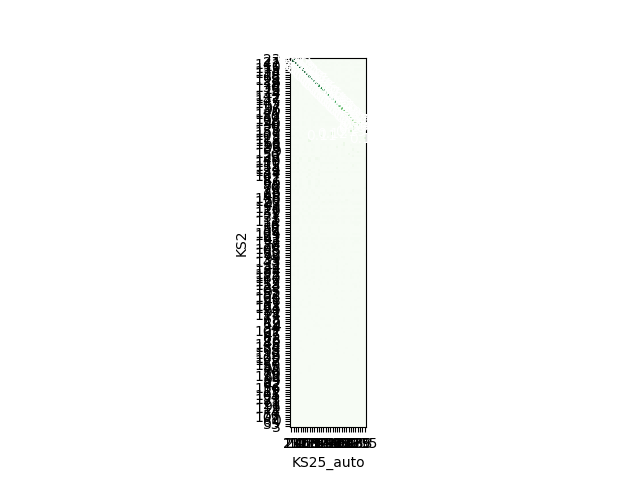

In [129]:
si.plot_agreement_matrix(comp_KS2_KS25auto)

### Compare multiple sorters

In 2020, the spike interface team publish an article to demonstrate that sorters do not agree on the results.
See this https://elifesciences.org/articles/61834

Here a direct illustration of the phenomenom on this dataset.

In [134]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25,], ['KS2', 'KS25', ], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


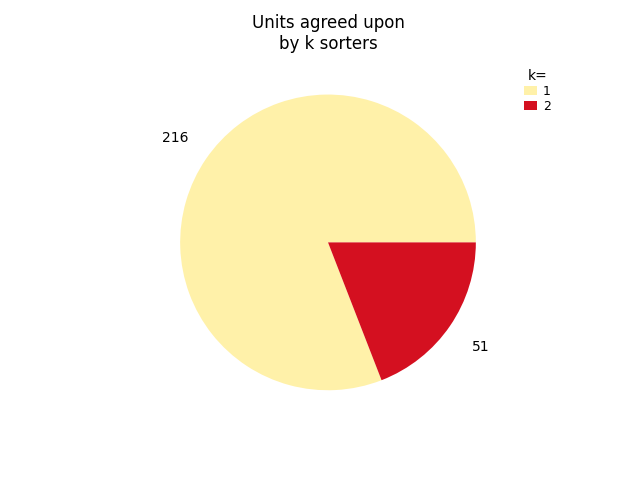

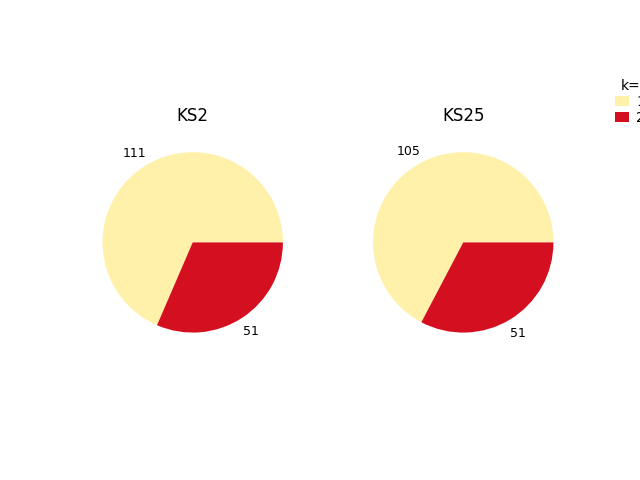

In [135]:
w = si.plot_multicomparison_agreement(mcmp)
w = si.plot_multicomparison_agreement_by_sorter(mcmp)

In [136]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 51 units - 1 segments - 30.0kHz


# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [138]:
si.export_to_phy(we, output_folder=base_folder / 'phy_KS25', 
                   compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
                   **job_kwargs)

Run:
phy template-gui  /data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023/phy_KS25/params.py


After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])

## Export a report to a folder



In [186]:
si.export_report(we, output_folder=base_folder / 'report_KS25')

### Et voilà!